In [3]:
import jax
from jax import random, vmap, jit, grad, value_and_grad
import jax.numpy as jnp
import optax
from functools import partial
from tqdm import trange
import matplotlib.pyplot as plt
import numpy as np
import time

In [54]:
class FeedForwardNN:
    def __init__(self, layer_sizes, key, activation_fn=jax.nn.tanh):
        self.layer_sizes = layer_sizes
        self.activation_fn = activation_fn
        self.params = self.initialize_params(layer_sizes, key)

    def initialize_params(self, layer_sizes, key):
        params = []
        keys = random.split(key, len(layer_sizes) - 1)
        for i in range(len(layer_sizes) - 1):
            W_key, b_key = random.split(keys[i])
            # Xavier initialization for weights
            in_dim = layer_sizes[i]
            out_dim = layer_sizes[i+1]
            W = random.uniform(W_key, (in_dim, out_dim), minval=-jnp.sqrt(6 / (in_dim + out_dim)), maxval=jnp.sqrt(6 / (in_dim + out_dim)))
            # Initialize biases with zeros
            b = jnp.zeros(out_dim)
            params.append((W, b))
        return params

    @partial(jit, static_argnums=(0,))
    def forward(self, params, x):
        for W, b in params[:-1]:
            # Linear transformation
            x = jnp.dot(x, W) + b
            # Apply activation function
            x = self.activation_fn(x)
        # Output layer (no activation function)
        W, b = params[-1]
        x = jnp.dot(x, W) + b
        return x

    def predict(self, x):
        # Predict output for input x
        return vmap(self.forward, in_axes=(None, 0))(self.params, x)

In [55]:
class DeepONet:
    def __init__(self, branch_layer_sizes, trunk_layer_sizes, key, activation_fn=jax.nn.tanh):
        # Initialize branch and trunk networks
        branch_key, trunk_key = random.split(key)
        self.branch_net = FeedForwardNN(branch_layer_sizes, branch_key, activation_fn)
        self.trunk_net = FeedForwardNN(trunk_layer_sizes, trunk_key, activation_fn)

    def params(self):
        return [self.branch_net.params, self.trunk_net.params]

    @partial(jit, static_argnums=(0,))
    def forward(self, params, branch_input, trunk_input):
        # Forward pass through branch and trunk networks
        branch_output = self.branch_net.forward(params[0], branch_input)
        trunk_output = self.trunk_net.forward(params[1], trunk_input)
        # Combine outputs using inner product
        return jnp.dot(branch_output, trunk_output.T)
    
    @partial(jit, static_argnums=(0,))
    def forward_squeeze(self, params, branch_input, trunk_input):
        return self.forward(params, branch_input, trunk_input).squeeze()

    def predict(self, branch_input, trunk_input):
        # Predict output for given inputs
        return vmap(self.forward, in_axes=(None, 0, 0))(self.params(), branch_input, trunk_input)

In [ ]:
# # Parameter omega
def generate_omega(omega_min, omega_max, n_samples, key):
    
    # # Normally distributed omega

    # Parameters for the true normal distribution
    mean = (omega_max + omega_min) / 2
    std = 2  # Smaller std = tighter around center

    # Rejection sampling: draw until we have enough inside bounds
    samples = []
    key_normal = random.PRNGKey(0)

    while len(samples) < n_samples:
        # Use JAX's random.normal instead of NumPy's
        proposed = random.normal(key, shape=(n_samples,)) * std + mean
        proposed = np.array(proposed)  # Convert to NumPy for boolean masking
        accepted = proposed[(proposed >= omega_min) & (proposed <= omega_max)]
        samples.extend(accepted.tolist())
        key, _ = random.split(key)  # Update key for next batch

    omega_normal = np.array(samples[:n_samples])

    # # Uniformly distributed omega

    key_uniform = random.PRNGKey(1)
    omega_uniform = random.uniform(
        key, shape=(n_samples,), minval=omega_min, maxval=omega_max
    )

    # # Beta distributed omega

    # Parameters for the beta distribution
    alpha = 0.4
    beta = 0.4

    # Generate beta-distributed samples in [0, 1]
    key_beta = random.PRNGKey(3)  # Using a different key for beta samples
    beta_samples = random.beta(key, alpha, beta, shape=(n_samples,))

    # Scale the beta samples to the desired range [omega_min, omega_max]
    omega_beta = omega_min + (omega_max - omega_min) * beta_samples

    return omega_normal, omega_uniform, omega_beta



In [ ]:

def initialize_DON(key=None):
    # Use the provided key or default to random.PRNGKey(0)
    if key is None:
        key = random.PRNGKey(0)

    # Create a neural network
    branch_layer_sizes = [1, 50, 50, 10]
    trunk_layer_sizes = [1, 50, 50, 10]
    nn = DeepONet(branch_layer_sizes, trunk_layer_sizes, key)

    return nn


def train_DON(nn, omega, x, y, max_iter, batch_sampling=False, batch_ratio=0.2):
    def loss_fn(params, omega, x, y):
        return jnp.mean(squared_residual_batch(params, omega, x)) + jnp.mean(
            squared_errors_batch(params, omega, x, y)
        )

    # Define training step with Adam optimizer
    @jit
    def train_step(params, opt_state, omega, x, y):
        loss, grads = jax.value_and_grad(loss_fn)(params, omega, x, y)
        updates, opt_state = optimizer.update(grads, opt_state)
        new_params = optax.apply_updates(params, updates)
        return new_params, opt_state, loss

    # Define the loss function
    u_x = jit(grad(nn.forward_squeeze, argnums=2))
    squared_residual = jit(
        lambda params, omega, x: (u_x(params, omega, x) - omega * jnp.cos(omega * x))
        ** 2
    )
    squared_residual_batch = jit(vmap(squared_residual, in_axes=(None, 0, 0)))

    # With or without data
    # squared_error = jit(lambda params, omega: nn.forward(params, omega, 0) ** 2)
    squared_error = jit(
        lambda params, omega, x, y: (nn.forward(params, omega, x) - y) ** 2
    )
    squared_errors_batch = jit(vmap(squared_error, in_axes=(None, 0, 0, 0)))

    # Training loop
    max_iterations = max_iter

    # Training loop with tqdm progress bar with batch sampling
    if batch_sampling:
        # Initialize the Adam optimizer with the learning rate schedule
        learning_rate_schedule = optax.piecewise_constant_schedule(
            init_value=0.01,
            boundaries_and_scales={300: 0.2, 2000: 0.5, 3000: 0.1, 4000: 0.1}
            # boundaries_and_scales={300: 0.2, 2000: 0.5},
        )
        optimizer = optax.adam(learning_rate=learning_rate_schedule)
        opt_state = optimizer.init(nn.params())
        losses = []

        pbar = trange(max_iterations, desc="Training", leave=True)
        for i, epoch in enumerate(pbar):
            
            idx = np.random.choice(len(omega),int(len(omega)*batch_ratio), replace = False)
            
            don_params, opt_state, current_loss = train_step(
                nn.params(), opt_state, omega[idx], x[idx], y[idx]
            )

            nn.branch_net.params = don_params[0]
            nn.trunk_net.params = don_params[1]
            losses.append(current_loss)
            if epoch % 100 == 0:
                pbar.set_postfix({"loss": current_loss})
            if current_loss < 1.0e-5:
                break
    else:
        # Initialize the Adam optimizer with the learning rate schedule
        learning_rate_schedule = optax.piecewise_constant_schedule(
            init_value=0.01, boundaries_and_scales={300: 0.2, 2000: 0.5}
        )
        optimizer = optax.adam(learning_rate=learning_rate_schedule)
        opt_state = optimizer.init(nn.params())
        losses = []

        # Training loop without batch sampling
        pbar = trange(max_iterations, desc="Training", leave=True)
        for i, epoch in enumerate(pbar):
            don_params, opt_state, current_loss = train_step(
                nn.params(), opt_state, omega, x, y
            )
            nn.branch_net.params = don_params[0]
            nn.trunk_net.params = don_params[1]
            losses.append(current_loss)
            if epoch % 100 == 0:
                pbar.set_postfix({"loss": current_loss})
            if current_loss < 1.0e-5:
                break

    return nn, losses


In [58]:

omega_min = -1.0
omega_max = 3 * np.pi

random_key = random.PRNGKey(42)  # Random key for JAX
n_samples = 1000
omega_normal, omega_uniform, omega_beta = generate_omega(omega_min, omega_max, n_samples, random_key)

omega = omega_beta

# Generate random x values between -1 and 1 with a different random key
key_x = random.PRNGKey(2)
x = random.uniform(key_x, shape=(n_samples,), minval=-1, maxval=1)

# Compute y values for the generated omega and x
y = jnp.sin(omega * x)

max_iterations = 5000

print(np.shape(omega))
print(np.shape(x))
print(np.shape(y))

nn = initialize_DON()

nn, losses = train_DON(
    nn, omega, x, y, max_iterations, False
)

nn_batch = initialize_DON()

nn_batch, losses_batch = train_DON(
    nn_batch, omega, x, y, max_iterations, True, 0.5
)

(1000,)
(1000,)
(1000,)


Training: 100%|██████████| 5000/5000 [00:41<00:00, 119.36it/s, loss=0.06642235] 


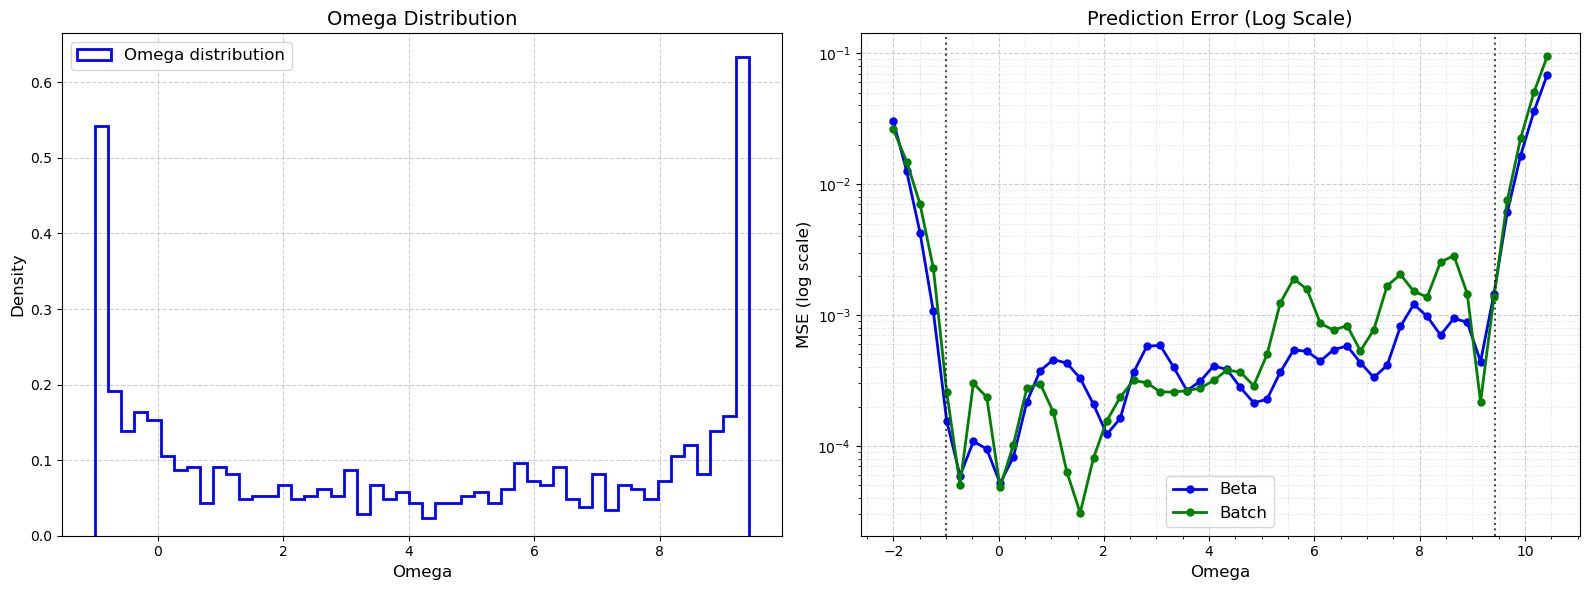

In [59]:
# Generate test data for x
x_test = jnp.linspace(-1.0, 1.0, 1000)

# Plot the final results for nn
n_test_omegas = 50  # Number of test omega values

# Generate equally spaced omega_test values
delta = 1
omega_tests = jnp.linspace(omega_min - delta, omega_max + delta, n_test_omegas)

mse_results = []
mse_batch_results = []

for omega_test in omega_tests:
    omega_test_array = jnp.ones_like(x_test) * omega_test
    y_test = jnp.sin(omega_test_array * x_test)

    mse = np.mean(
        (y_test - nn.predict(omega_test_array, x_test).reshape(y_test.shape)) ** 2
    )

    mse_batch = np.mean(
        (y_test - nn_batch.predict(omega_test_array, x_test).reshape(y_test.shape)) ** 2
    )

    mse_results.append(mse)
    mse_batch_results.append(mse_batch)

# Plot MSE vs Omega (optional)

colors = ["b", "g", "r", "c", "m"]

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- First subplot: Omega distributions ---
ax1.hist(omega, bins=50, density=True, histtype="step", 
         linewidth=2, label="Omega distribution", color=colors[0])

ax1.set_xlabel("Omega", fontsize=12)
ax1.set_ylabel("Density", fontsize=12)
ax1.set_title("Omega Distribution", fontsize=14)
ax1.legend(fontsize=12)
ax1.grid(True, linestyle="--", alpha=0.6)

# --- Second subplot: MSE results (log scale) ---
ax2.semilogy(omega_tests, mse_results, "o-", linewidth=2, 
             markersize=5, label="Beta", color=colors[0])
ax2.semilogy(omega_tests, mse_batch_results, "o-", linewidth=2,
             markersize=5, label="Batch", color=colors[1])

# Add vertical dotted lines at boundaries
ax2.axvline(omega_min, color='k', linestyle=':', alpha=0.7, linewidth=1.5)
ax2.axvline(omega_max, color='k', linestyle=':', alpha=0.7, linewidth=1.5)

ax2.set_xlabel("Omega", fontsize=12)
ax2.set_ylabel("MSE (log scale)", fontsize=12)
ax2.set_title("Prediction Error (Log Scale)", fontsize=14)
ax2.legend(fontsize=12)
ax2.grid(True, linestyle="--", alpha=0.6, which='both')

# Add minor grid lines for the log scale
ax2.minorticks_on()
ax2.grid(which='minor', linestyle=':', alpha=0.4)

plt.tight_layout()
plt.show()


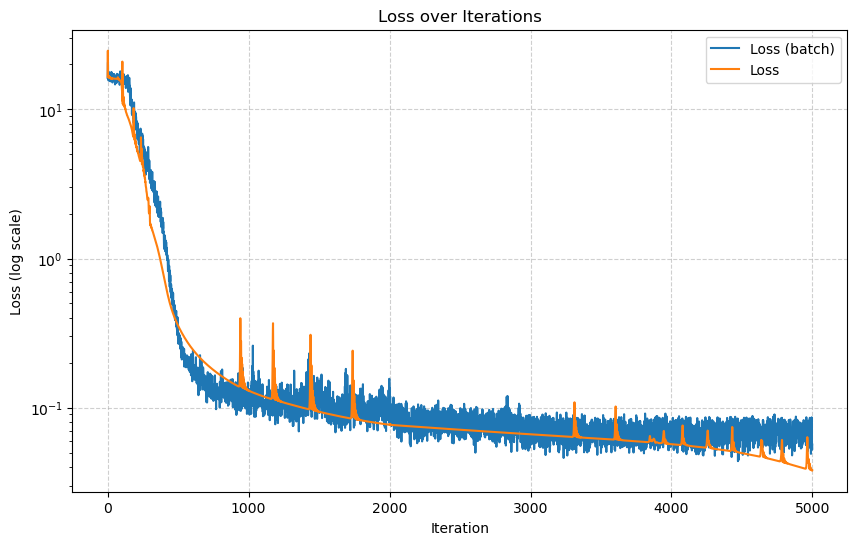

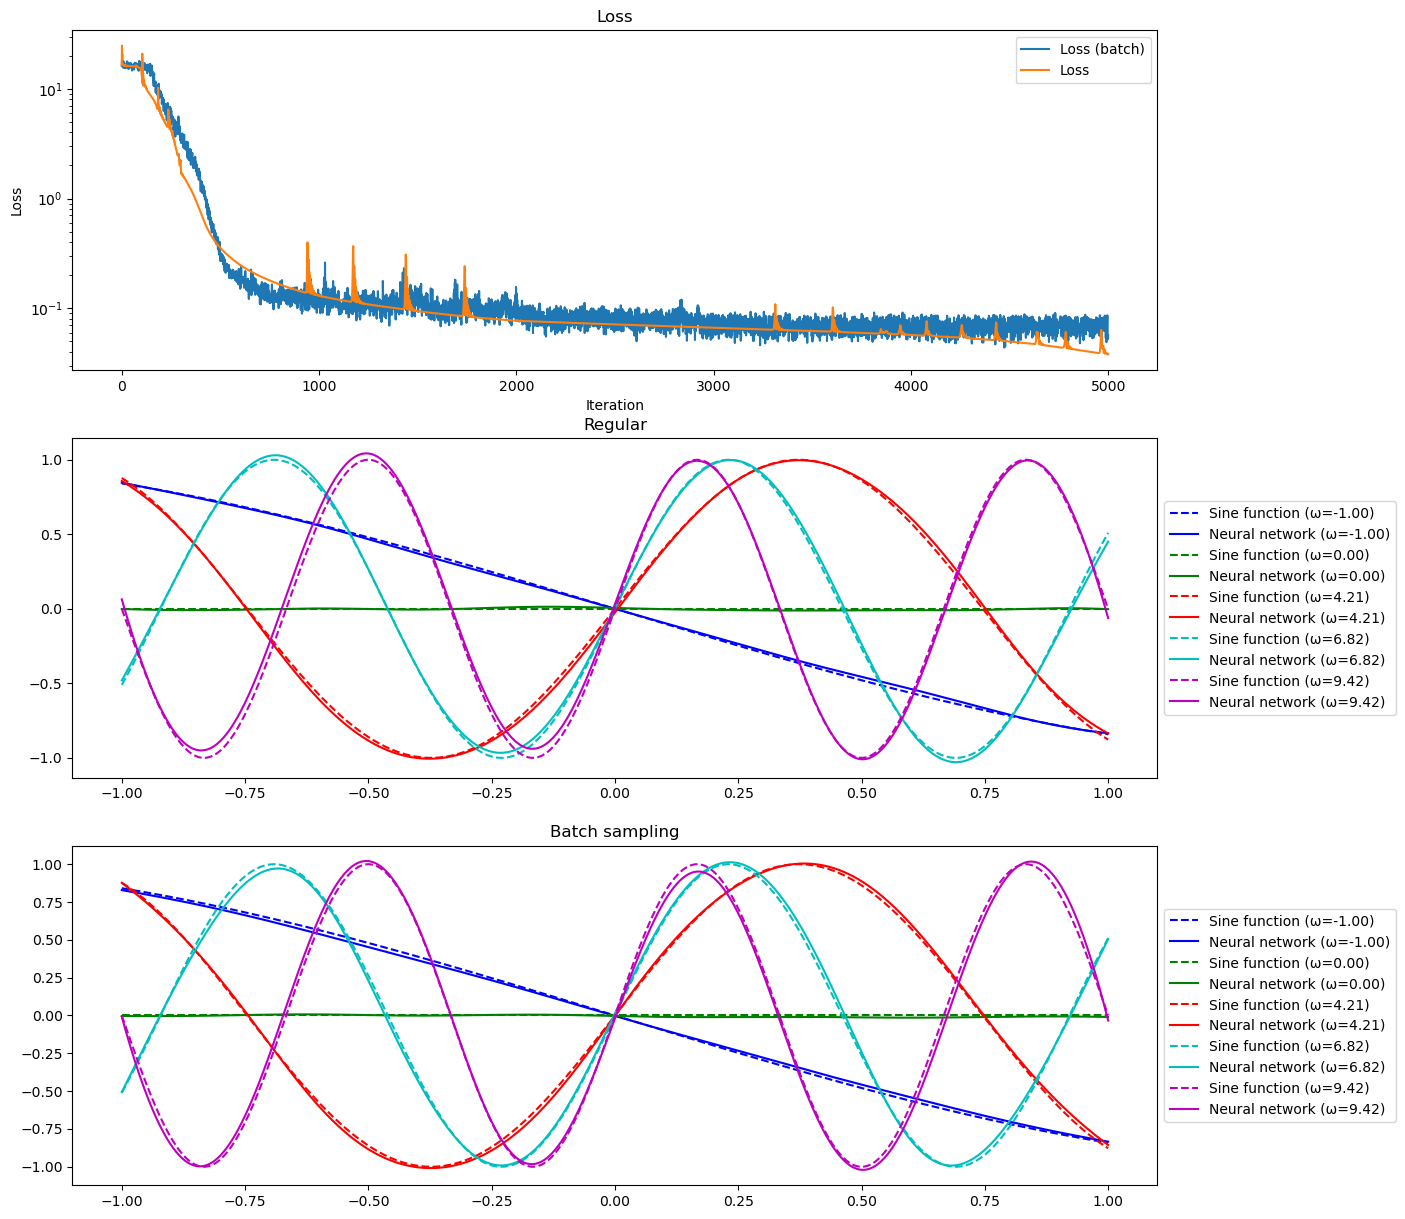

In [60]:


# Plot the loss over the number of iterations for nn

plt.figure(figsize=(10, 6))
plt.plot(range(len(losses_batch)), losses_batch, label="Loss (batch)")
plt.plot(range(len(losses)), losses, label="Loss")
plt.yscale("log")
plt.title("Loss over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss (log scale)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()


# Plot the results for nn
# Create a figure with two subplots
fig, axs = plt.subplots(3, 1, figsize=(14, 15))

# Plot the loss over the number of iterations for nn
axs[0].set_yscale("log")
axs[0].plot(range(len(losses_batch)), losses_batch, label="Loss (batch)")
axs[0].plot(range(len(losses)), losses, label="Loss")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss")
axs[0].legend()

# Plot the final results for nn
omega_tests = jnp.linspace(omega_min, omega_max, 5)
# key_uniform = random.PRNGKey(10)
# omega_tests = random.uniform(key_uniform, shape=(5,), minval=omega_min, maxval=omega_max)
omega_tests = omega_tests.at[1].set(0)

colors = ["b", "g", "r", "c", "m"]

# fig, axs = plt.subplots(1, 1, figsize=(10, 6))  # Adjust layout if needed

for omega_test, color in zip(omega_tests, colors):
    omega_test_array = jnp.ones_like(x_test) * omega_test
    y_test = jnp.sin(omega_test_array * x_test)
    # Plot true sine function (dashed line)
    axs[1].plot(
        x_test,
        y_test,
        color=color,
        linestyle="--",
        label=f"Sine function (ω={float(omega_test):.2f})",  # Round to 2 decimals
    )

    # Plot neural network prediction (solid line)
    axs[1].plot(
        x_test,
        nn.predict(omega_test_array, x_test).reshape(y_test.shape),
        color=color,
        label=f"Neural network (ω={float(omega_test):.2f})",  # Round to 2 decimals
    )

    axs[2].plot(
        x_test,
        y_test,
        color=color,
        linestyle="--",
        label=f"Sine function (ω={float(omega_test):.2f})",  # Round to 2 decimals
    )

    # Plot neural network prediction (solid line)
    axs[2].plot(
        x_test,
        nn_batch.predict(omega_test_array, x_test).reshape(y_test.shape),
        color=color,
        label=f"Neural network (ω={float(omega_test):.2f})",  # Round to 2 decimals
    )

# Add legend outside the plot
axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Set titles for each subplot
axs[0].set_title("Loss")
axs[1].set_title("Regular")
axs[2].set_title("Batch sampling") 

plt.show()

In [61]:
# Generate test data for x
x_test = jnp.linspace(-1.0, 1.0, 1000)

# Plot the final results for nn
n_test_omegas = 50  # Number of test omega values

# Generate equally spaced omega_test values
delta = 1
omega_tests = jnp.linspace(omega_min - delta, omega_max + delta, n_test_omegas)

# Number of repetitions for training
num_repeats = 5

all_mse_results = []
all_mse_batch_results = []

n_samples = 1000
max_iterations = 5000
max_iterations_batch = 5000

batch_ratio = 0.6

total_time_nn = 0
total_time_nn_batch = 0

key_adjust = 42

for i in range(num_repeats):
    print(f"Training repetition {i + 1}/{num_repeats}")

    random_key = random.PRNGKey(key_adjust + i)  # Random key for JAX
    omega_normal, omega_uniform, omega_beta = generate_omega(omega_min, omega_max, n_samples, random_key)
    omega = omega_beta

    # Generate random x values between -1 and 1 with a different random key
    key_x = random.PRNGKey(key_adjust + i)
    x = random.uniform(key_x, shape=(n_samples,), minval=-1, maxval=1)

    # Compute y values for the generated omega and x
    y = jnp.sin(omega * x)

    # Train DON models
    random_key = random.PRNGKey(key_adjust + 2 * num_repeats + i)
    
    # Time training for nn
    nn = initialize_DON(random_key)
    start_time = time.time()
    nn, losses = train_DON(nn, omega, x, y, max_iterations, False)
    end_time = time.time()
    total_time_nn += (end_time - start_time)

    # Time training for nn_batch
    nn_batch = initialize_DON(random_key)
    start_time = time.time()
    nn_batch, losses_batch = train_DON(nn_batch, omega, x, y, max_iterations_batch, True, batch_ratio)
    end_time = time.time()
    total_time_nn_batch += (end_time - start_time)

    # Compute MSE for each omega_test
    mse_results = []
    mse_batch_results = []

    for omega_test in omega_tests:
        omega_test_array = jnp.ones_like(x_test) * omega_test
        y_test = jnp.sin(omega_test_array * x_test)

        mse = np.mean(
            (y_test - nn.predict(omega_test_array, x_test).reshape(y_test.shape))
            ** 2
        )
        mse_batch = np.mean(
            (y_test - nn_batch.predict(omega_test_array, x_test).reshape(y_test.shape))
            ** 2
        )

        mse_results.append(mse)
        mse_batch_results.append(mse_batch)

    # Store results for this repetition
    all_mse_results.append(mse_results)
    all_mse_batch_results.append(mse_batch_results)

# Compute mean MSE across all repetitions for each omega
mean_mse = np.mean(all_mse_results, axis=0)
mean_mse_batch = np.mean(all_mse_batch_results, axis=0)

average_time_nn = total_time_nn / num_repeats
average_time_nn_batch = total_time_nn_batch / num_repeats

print(f"Average training time for nn: {average_time_nn:.2f} seconds")
print(f"Average training time for nn_batch: {average_time_nn_batch:.2f} seconds")

# Plot mean MSE vs Omega
colors = ["b", "g", "r"]

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot mean MSE results (log scale)
ax.semilogy(
    omega_tests,
    mean_mse,
    "o-",
    linewidth=2,
    markersize=5,
    label="Regular",
    color=colors[0],
)
ax.semilogy(
    omega_tests,
    mean_mse_batch,
    "o-",
    linewidth=2,
    markersize=5,
    label="Batch",
    color=colors[1],
)

# Add vertical dotted lines at boundaries
ax.axvline(omega_min, color="k", linestyle=":", alpha=0.7, linewidth=1.5)
ax.axvline(omega_max, color="k", linestyle=":", alpha=0.7, linewidth=1.5)

ax.set_xlabel("Omega", fontsize=12)
ax.set_ylabel("Mean MSE (log scale)", fontsize=12)
ax.set_title("Mean Prediction Error (Log Scale)", fontsize=14)
ax.legend(fontsize=12)
ax.grid(True, linestyle="--", alpha=0.6, which="both")

# Add minor grid lines for the log scale
ax.minorticks_on()
ax.grid(which="minor", linestyle=":", alpha=0.4)

plt.tight_layout()
plt.show()

Training repetition 1/5


Training: 100%|██████████| 5000/5000 [00:45<00:00, 110.09it/s, loss=0.09484445] 


Training repetition 2/5


Training:  24%|██▍       | 1196/5000 [00:15<00:48, 77.91it/s, loss=0.099681996] 


KeyboardInterrupt: 

In [63]:
# Generate test data for x
x_test = jnp.linspace(-1.0, 1.0, 1000)

# Plot the final results for nn
n_test_omegas = 200  # Number of test omega values

# Generate equally spaced omega_test values
delta = 1
omega_trains = jnp.linspace(omega_min, omega_max, n_test_omegas)
omega_test_temp1 = jnp.linspace(omega_min - delta, omega_min, int(0.5*n_test_omegas))
omega_test_temp2 = jnp.linspace(omega_max, omega_max + delta, int(0.5*n_test_omegas))
omega_tests = jnp.concatenate((omega_test_temp1, omega_test_temp2))

# Number of repetitions for training
batch_ratios = [0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 0.99]
# batch_ratios = [0.05, 0.1]

n_samples = 1000
max_iterations = 5000
max_iterations_batch = 5000

mean_mse_train = []
mean_mse_train_batch = []

mean_mse_test = []
mean_mse_test_batch = []

num_repeats = 10

key_adjust = 42

all_mse_train_results = []
all_mse_test_results = []
total_time_nn = 0

for i in range(num_repeats):
    print(f"Training repetition {i + 1}/{num_repeats}")

    random_key = random.PRNGKey((i+1)*key_adjust + i)  # Random key for JAX
    omega_normal, omega_uniform, omega_beta = generate_omega(omega_min, omega_max, n_samples, random_key)
    omega = omega_beta

    # Generate random x values between -1 and 1 with a different random key
    key_x = random.PRNGKey((i+1)*key_adjust + i)
    x = random.uniform(key_x, shape=(n_samples,), minval=-1, maxval=1)

    # Compute y values for the generated omega and x
    y = jnp.sin(omega * x)

    # Train DON models
    random_key = random.PRNGKey((i+1)*key_adjust + 2 * num_repeats + i)
    
    # Time training for nn
    nn = initialize_DON(random_key)
    start_time = time.time()
    nn, losses = train_DON(nn, omega, x, y, max_iterations, False)
    end_time = time.time()
    total_time_nn += (end_time - start_time)

    # Compute MSE for each omega_test
    mse_test_results = []

    mse_train_results = []

    for omega_train in omega_trains:

        omega_train_array = jnp.ones_like(x_test) * omega_train
        y_train = jnp.sin(omega_train_array * x_test)
        
        mse_train = np.mean(
            (y_train - nn.predict(omega_train_array, x_test).reshape(y_train.shape))
            ** 2
        )

        mse_train_results.append(mse_train)

    for omega_test in omega_tests:

        omega_test_array = jnp.ones_like(x_test) * omega_test
        y_test = jnp.sin(omega_test_array * x_test)

        mse_test = np.mean(
            (y_test - nn.predict(omega_test_array, x_test).reshape(y_test.shape))
            ** 2
        )
        
        mse_test_results.append(mse_test)

    # Store results for this repetition
    all_mse_train_results.append(np.mean(mse_train_results))

    all_mse_test_results.append(np.mean(mse_test_results))

# Compute mean MSE across all repetitions for each omega
mean_mse_train.append(np.mean(all_mse_train_results))

mean_mse_test.append(np.mean(all_mse_test_results))

average_time_nn = total_time_nn / num_repeats

print(f"Average training time for nn: {average_time_nn:.2f} seconds")

for j in range(len(batch_ratios)):
    
    batch_ratio = batch_ratios[j]
    print(f"Batch ratio {batch_ratio}")

    all_mse_train_batch_results = []

    all_mse_test_batch_results = []

    total_time_nn_batch = 0

    for i in range(num_repeats):
        print(f"Training repetition {i + 1}/{num_repeats}")

        random_key = random.PRNGKey((j+1)*key_adjust + i)  # Random key for JAX
        omega_normal, omega_uniform, omega_beta = generate_omega(omega_min, omega_max, n_samples, random_key)
        omega = omega_beta

        # Generate random x values between -1 and 1 with a different random key
        key_x = random.PRNGKey((j+1)*key_adjust + i)
        x = random.uniform(key_x, shape=(n_samples,), minval=-1, maxval=1)

        # Compute y values for the generated omega and x
        y = jnp.sin(omega * x)

        # Train DON models
        random_key = random.PRNGKey((j+1)*key_adjust + 2 * num_repeats + i)
        
        # Time training for nn_batch
        nn_batch = initialize_DON(random_key)
        start_time = time.time()
        nn_batch, losses_batch = train_DON(nn_batch, omega, x, y, max_iterations_batch, True, batch_ratio)
        end_time = time.time()
        total_time_nn_batch += (end_time - start_time)

        # Compute MSE for each omega_test
        mse_test_batch_results = []

        mse_train_batch_results = []

        for omega_train in omega_trains:

            omega_train_array = jnp.ones_like(x_test) * omega_train
            y_train = jnp.sin(omega_train_array * x_test)
            
            mse_train_batch = np.mean(
                (y_train - nn_batch.predict(omega_train_array, x_test).reshape(y_train.shape))
                ** 2
            )

            mse_train_batch_results.append(mse_train_batch)

        for omega_test in omega_tests:

            omega_test_array = jnp.ones_like(x_test) * omega_test
            y_test = jnp.sin(omega_test_array * x_test)

            mse_test_batch = np.mean(
                (y_test - nn_batch.predict(omega_test_array, x_test).reshape(y_test.shape))
                ** 2
            )

            mse_test_batch_results.append(mse_test_batch)

        # Store results for this repetition
        all_mse_train_batch_results.append(np.mean(mse_train_batch_results))

        all_mse_test_batch_results.append(np.mean(mse_test_batch_results))

    # Compute mean MSE across all repetitions for each omega
    mean_mse_train_batch.append(np.mean(all_mse_train_batch_results))

    mean_mse_test_batch.append(np.mean(all_mse_test_batch_results))

    average_time_nn_batch = total_time_nn_batch / num_repeats

    print(f"Average training time for nn_batch: {average_time_nn_batch:.2f} seconds")


Training repetition 1/10


Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training: 100%|██████████| 5000/5000 [00:43<00:00, 114.35it/s, loss=0.022469126]


Training repetition 2/10


Training: 100%|██████████| 5000/5000 [00:34<00:00, 145.92it/s, loss=0.014252759]


Training repetition 3/10


Training: 100%|██████████| 5000/5000 [00:33<00:00, 147.15it/s, loss=0.049223408]


Training repetition 4/10


Training: 100%|██████████| 5000/5000 [00:36<00:00, 138.48it/s, loss=0.048859198]


Training repetition 5/10


Training: 100%|██████████| 5000/5000 [00:33<00:00, 149.64it/s, loss=0.02782131] 


Training repetition 6/10


Training: 100%|██████████| 5000/5000 [00:35<00:00, 140.68it/s, loss=0.01072563] 


Training repetition 7/10


Training: 100%|██████████| 5000/5000 [00:35<00:00, 140.12it/s, loss=0.016932309]


Training repetition 8/10


Training: 100%|██████████| 5000/5000 [00:35<00:00, 141.88it/s, loss=0.011840568]


Training repetition 9/10


Training: 100%|██████████| 5000/5000 [00:44<00:00, 112.63it/s, loss=0.013292202]


Training repetition 10/10


Training: 100%|██████████| 5000/5000 [00:34<00:00, 144.79it/s, loss=0.008939545]


Average training time for nn: 36.74 seconds
Batch ratio 0.01
Training repetition 1/10


Training: 100%|██████████| 5000/5000 [00:23<00:00, 213.54it/s, loss=16.231047] 


Training repetition 2/10


Training: 100%|██████████| 5000/5000 [00:24<00:00, 202.90it/s, loss=27.753048]


Training repetition 3/10


Training: 100%|██████████| 5000/5000 [00:23<00:00, 209.71it/s, loss=18.561752]


Training repetition 4/10


Training: 100%|██████████| 5000/5000 [00:24<00:00, 206.37it/s, loss=16.064253]


Training repetition 5/10


Training: 100%|██████████| 5000/5000 [00:24<00:00, 204.47it/s, loss=19.32515] 


Training repetition 6/10


Training: 100%|██████████| 5000/5000 [00:23<00:00, 211.30it/s, loss=25.236034] 


Training repetition 7/10


Training: 100%|██████████| 5000/5000 [00:23<00:00, 209.46it/s, loss=13.362303]


Training repetition 8/10


Training: 100%|██████████| 5000/5000 [00:23<00:00, 213.99it/s, loss=22.55058] 


Training repetition 9/10


Training: 100%|██████████| 5000/5000 [00:26<00:00, 188.37it/s, loss=20.314772]


Training repetition 10/10


Training: 100%|██████████| 5000/5000 [00:24<00:00, 200.92it/s, loss=10.6372175]


Average training time for nn_batch: 24.34 seconds
Batch ratio 0.1
Training repetition 1/10


Training: 100%|██████████| 5000/5000 [00:29<00:00, 171.99it/s, loss=0.20031412] 


Training repetition 2/10


Training: 100%|██████████| 5000/5000 [00:26<00:00, 189.29it/s, loss=0.17768353]


Training repetition 3/10


Training: 100%|██████████| 5000/5000 [00:26<00:00, 192.09it/s, loss=0.14738677]


Training repetition 4/10


Training: 100%|██████████| 5000/5000 [00:26<00:00, 189.26it/s, loss=0.0780367]  


Training repetition 5/10


Training: 100%|██████████| 5000/5000 [00:27<00:00, 184.03it/s, loss=0.17374375]


Training repetition 6/10


Training: 100%|██████████| 5000/5000 [00:26<00:00, 187.84it/s, loss=0.15526603]


Training repetition 7/10


Training: 100%|██████████| 5000/5000 [00:30<00:00, 164.92it/s, loss=2.1966138]


Training repetition 8/10


Training: 100%|██████████| 5000/5000 [00:26<00:00, 186.79it/s, loss=0.17676246] 


Training repetition 9/10


Training: 100%|██████████| 5000/5000 [00:26<00:00, 190.90it/s, loss=0.34331876]


Training repetition 10/10


Training: 100%|██████████| 5000/5000 [00:27<00:00, 184.46it/s, loss=0.14092875]


Average training time for nn_batch: 27.26 seconds
Batch ratio 0.2
Training repetition 1/10


Training: 100%|██████████| 5000/5000 [00:28<00:00, 176.67it/s, loss=0.09085083] 


Training repetition 2/10


Training: 100%|██████████| 5000/5000 [00:28<00:00, 177.27it/s, loss=0.2964996] 


Training repetition 3/10


Training: 100%|██████████| 5000/5000 [00:28<00:00, 174.46it/s, loss=0.20202085]


Training repetition 4/10


Training: 100%|██████████| 5000/5000 [00:28<00:00, 173.35it/s, loss=0.12965775]


Training repetition 5/10


Training: 100%|██████████| 5000/5000 [00:28<00:00, 177.57it/s, loss=0.1594582] 


Training repetition 6/10


Training: 100%|██████████| 5000/5000 [00:27<00:00, 182.79it/s, loss=0.12043185] 


Training repetition 7/10


Training: 100%|██████████| 5000/5000 [00:27<00:00, 180.45it/s, loss=0.20771764]


Training repetition 8/10


Training: 100%|██████████| 5000/5000 [00:32<00:00, 152.97it/s, loss=0.18906553]


Training repetition 9/10


Training: 100%|██████████| 5000/5000 [00:32<00:00, 153.07it/s, loss=0.120240204]


Training repetition 10/10


Training: 100%|██████████| 5000/5000 [00:33<00:00, 148.93it/s, loss=0.22551146]


Average training time for nn_batch: 29.66 seconds
Batch ratio 0.5
Training repetition 1/10


Training: 100%|██████████| 5000/5000 [00:48<00:00, 102.85it/s, loss=0.016821414]


Training repetition 2/10


Training: 100%|██████████| 5000/5000 [00:43<00:00, 113.87it/s, loss=0.065145776]


Training repetition 3/10


Training: 100%|██████████| 5000/5000 [00:43<00:00, 114.96it/s, loss=0.1175719]  


Training repetition 4/10


Training: 100%|██████████| 5000/5000 [00:41<00:00, 121.15it/s, loss=0.09297113] 


Training repetition 5/10


Training: 100%|██████████| 5000/5000 [00:41<00:00, 121.69it/s, loss=0.16777465]


Training repetition 6/10


Training: 100%|██████████| 5000/5000 [00:42<00:00, 117.42it/s, loss=0.059407253]


Training repetition 7/10


Training: 100%|██████████| 5000/5000 [00:45<00:00, 110.63it/s, loss=0.062234156]


Training repetition 8/10


Training: 100%|██████████| 5000/5000 [00:42<00:00, 118.57it/s, loss=0.12226855] 


Training repetition 9/10


Training: 100%|██████████| 5000/5000 [00:41<00:00, 120.50it/s, loss=0.09732097] 


Training repetition 10/10


Training: 100%|██████████| 5000/5000 [00:41<00:00, 120.49it/s, loss=0.10701779] 


Average training time for nn_batch: 43.18 seconds
Batch ratio 0.8
Training repetition 1/10


Training: 100%|██████████| 5000/5000 [00:49<00:00, 101.43it/s, loss=0.088141836]


Training repetition 2/10


Training: 100%|██████████| 5000/5000 [00:47<00:00, 104.45it/s, loss=0.07784893] 


Training repetition 3/10


Training: 100%|██████████| 5000/5000 [00:45<00:00, 110.45it/s, loss=0.099086255]


Training repetition 4/10


Training: 100%|██████████| 5000/5000 [00:47<00:00, 104.94it/s, loss=0.06116622] 


Training repetition 5/10


Training: 100%|██████████| 5000/5000 [00:47<00:00, 104.65it/s, loss=0.049633376]


Training repetition 6/10


Training: 100%|██████████| 5000/5000 [00:46<00:00, 107.86it/s, loss=0.08691867] 


Training repetition 7/10


Training: 100%|██████████| 5000/5000 [00:47<00:00, 105.22it/s, loss=0.03861719] 


Training repetition 8/10


Training: 100%|██████████| 5000/5000 [00:47<00:00, 104.37it/s, loss=0.06650143] 


Training repetition 9/10


Training: 100%|██████████| 5000/5000 [00:46<00:00, 107.17it/s, loss=0.27490705]


Training repetition 10/10


Training: 100%|██████████| 5000/5000 [00:49<00:00, 100.97it/s, loss=0.068144806]


Average training time for nn_batch: 47.63 seconds
Batch ratio 0.9
Training repetition 1/10


Training: 100%|██████████| 5000/5000 [00:55<00:00, 90.40it/s, loss=0.031771727] 


Training repetition 2/10


Training: 100%|██████████| 5000/5000 [00:57<00:00, 87.03it/s, loss=0.025948523] 


Training repetition 3/10


Training: 100%|██████████| 5000/5000 [00:52<00:00, 95.57it/s, loss=0.03415006]  


Training repetition 4/10


Training: 100%|██████████| 5000/5000 [00:53<00:00, 93.71it/s, loss=0.055642556] 


Training repetition 5/10


Training: 100%|██████████| 5000/5000 [00:55<00:00, 90.43it/s, loss=0.035760064] 


Training repetition 6/10


Training: 100%|██████████| 5000/5000 [00:57<00:00, 86.48it/s, loss=0.05623244]  


Training repetition 7/10


Training: 100%|██████████| 5000/5000 [00:56<00:00, 88.09it/s, loss=0.047100518] 


Training repetition 8/10


Training: 100%|██████████| 5000/5000 [00:56<00:00, 89.09it/s, loss=0.054581486] 


Training repetition 9/10


Training: 100%|██████████| 5000/5000 [00:51<00:00, 96.49it/s, loss=0.08677575]  


Training repetition 10/10


Training: 100%|██████████| 5000/5000 [00:52<00:00, 95.16it/s, loss=0.07504973]  


Average training time for nn_batch: 54.93 seconds
Batch ratio 0.95
Training repetition 1/10


Training: 100%|██████████| 5000/5000 [00:53<00:00, 92.74it/s, loss=0.030734759] 


Training repetition 2/10


Training: 100%|██████████| 5000/5000 [00:53<00:00, 93.28it/s, loss=0.020178936] 


Training repetition 3/10


Training: 100%|██████████| 5000/5000 [00:53<00:00, 92.63it/s, loss=0.080768645] 


Training repetition 4/10


Training: 100%|██████████| 5000/5000 [00:54<00:00, 92.52it/s, loss=0.095754854] 


Training repetition 5/10


Training: 100%|██████████| 5000/5000 [00:51<00:00, 96.21it/s, loss=0.033891182] 


Training repetition 6/10


Training: 100%|██████████| 5000/5000 [00:55<00:00, 90.40it/s, loss=0.06298356]  


Training repetition 7/10


Training: 100%|██████████| 5000/5000 [00:57<00:00, 87.49it/s, loss=0.0499707]   


Training repetition 8/10


Training: 100%|██████████| 5000/5000 [00:53<00:00, 93.84it/s, loss=0.039154842] 


Training repetition 9/10


Training: 100%|██████████| 5000/5000 [00:56<00:00, 89.24it/s, loss=0.014908786] 


Training repetition 10/10


Training: 100%|██████████| 5000/5000 [00:56<00:00, 88.72it/s, loss=0.056574974] 


Average training time for nn_batch: 54.62 seconds
Batch ratio 0.99
Training repetition 1/10


Training: 100%|██████████| 5000/5000 [00:59<00:00, 84.17it/s, loss=0.020808443] 


Training repetition 2/10


Training: 100%|██████████| 5000/5000 [00:57<00:00, 87.46it/s, loss=0.052823238] 


Training repetition 3/10


Training: 100%|██████████| 5000/5000 [00:54<00:00, 91.84it/s, loss=0.029847037] 


Training repetition 4/10


Training: 100%|██████████| 5000/5000 [00:55<00:00, 89.99it/s, loss=0.062114798] 


Training repetition 5/10


Training: 100%|██████████| 5000/5000 [00:54<00:00, 92.31it/s, loss=0.051319733] 


Training repetition 6/10


Training: 100%|██████████| 5000/5000 [00:53<00:00, 93.81it/s, loss=0.07446709]  


Training repetition 7/10


Training: 100%|██████████| 5000/5000 [00:54<00:00, 92.09it/s, loss=0.027608676] 


Training repetition 8/10


Training: 100%|██████████| 5000/5000 [00:57<00:00, 87.50it/s, loss=0.03527926]  


Training repetition 9/10


Training: 100%|██████████| 5000/5000 [00:56<00:00, 88.70it/s, loss=0.04401924]  


Training repetition 10/10


Training: 100%|██████████| 5000/5000 [00:56<00:00, 88.64it/s, loss=0.04853465]  


Average training time for nn_batch: 55.88 seconds


In [2]:
# Print mean MSE (if needed)
# print(mean_mse)

# Plot mean MSE vs Omega
colors = ["b", "g", "r"]

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot batch test/train MSE (varying with batch_ratios)
ax.semilogy(
    batch_ratios,
    mean_mse_test_batch,
    "o--",
    linewidth=2,
    markersize=5,
    label="Batch $\Omega_{train}\setminus \Omega$",
    color=colors[1],
)
ax.semilogy(
    batch_ratios,
    mean_mse_train_batch,
    "o-",
    linewidth=2,
    markersize=5,
    label="Batch $\omega \in I_{train}$",
    color=colors[1],
)

# Plot constant test/train MSE as horizontal lines
ax.axhline(
    y=mean_mse_test,
    color=colors[0],
    linestyle="--",
    linewidth=2,
    label="Baseline $\omega \in I_{test}$",
)
ax.axhline(
    y=mean_mse_train,
    color=colors[0],
    linestyle="-",
    linewidth=2,
    label="Baseline $\omega \in I_{train}$",
)

# Labels and formatting
ax.set_xlabel("Batch ratio", fontsize=12)
ax.set_ylabel("Mean MSE (log scale)", fontsize=12)
ax.set_title("Mean Prediction Error (Log Scale)", fontsize=14)
ax.legend(fontsize=12)
ax.grid(True, linestyle="--", alpha=0.6, which="both")

# Add minor grid lines for the log scale
ax.minorticks_on()
ax.grid(which="minor", linestyle=":", alpha=0.4)

plt.tight_layout()
plt.show()


NameError: name 'plt' is not defined